# Trends and Averages for Summer Months for MACAv2-CMIP5

## Imports

In [1]:
import xarray as xr
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
import dask
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs # for projection
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
#from matplotlib.colors import TwoSlopeNorm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import sys

## Functions

## Inputs

In [2]:
file_base = "/storage/group/pches/default/public/MACA-CMIP5/raw/macav2metdata_"
models = ["BNU-ESM", "CNRM-CM5", "CSIRO-Mk3-6-0", "CanESM2", "GFDL-ESM2G", "GFDL-ESM2M", "HadGEM2-CC365", "HadGEM2-ES365", "IPSL-CM5A-LR",
         "IPSL-CM5A-MR", "IPSL-CM5B-LR", "MIROC-ESM-CHEM", "MIROC-ESM", "MIROC5", "bcc-csm1-1-m", "MRI-CGCM3", "bcc-csm1-1", "inmcm4"]
fwi_input_fields = ["rhsmin", "tasmax", "pr"]
#fwi_input_fields = ["tasmax", "pr"]
input_field_long = ['relative_humidity', 'air_temperature', 'precipitation_amount']
#input_field_long = ['air_temperature', 'precipitation_amount']

possible_scenario_str = ['rcp45', 'historical']
start_year, end_year = 1979, 2025
lon_max = -114.016667
lon_min = -124.766667
lat_min = 32.025
lat_max = 50
start_day = 152
end_day = 304

In [3]:
def model_trend(model_i):
    '''
    given some model name, returns the climatology of the windspeed for MACAv2 CMIP5 
    inputs
    - model_i
    outputs
    - single xarray trendmap for model_i for var_i?
    '''
    input_field_paths = sorted(glob.glob(f'{file_base}{input_field}_{model_i}*'))
    correct_paths = []
    for path_i in input_field_paths:
        start_year_i = int(path_i.split("_")[-4])
        end_year_i = int(path_i.split("_")[-3])
        if ((start_year_i >= start_year) and (end_year_i <= end_year)) or (end_year_i == start_year) or (start_year_i == end_year):
            if path_i.split("_")[-5] in possible_scenario_str:
                correct_paths.append(path_i)
                
    # now we can do something with the "correct" correct_paths list 
    ds_model_i = xr.open_mfdataset(correct_paths, chunks='auto')
    ds_model_i["lon"] = np.where(ds_model_i["lon"] > 180, ds_model_i["lon"] - 360, ds_model_i["lon"])
    ds_model_i = ds_model_i.where((ds_model_i.lon >= lon_min) & (ds_model_i.lon <= lon_max) & 
                                    (ds_model_i.lat >= lat_min) & (ds_model_i.lat <= lat_max), drop=True)
    ds_model_i = ds_model_i.sel(time=~((ds_model_i.time.dt.month == 2) & (ds_model_i.time.dt.day == 29)))
    
    ds_model_i = ds_model_i.sel(time=slice(f"{start_year}-01-01", f"2022-12-31"))
    mask = (ds_model_i["time"].dt.dayofyear >= start_day) & (ds_model_i["time"].dt.dayofyear <= end_day)
    ds_model_i = ds_model_i.where(mask, drop=True)
    ds_annual = ds_model_i.groupby("time.year").mean(dim="time")
    
    key = list(ds_annual.keys())[0]
    yearly_mean = ds_annual.mean(dim='year')
    poly_coeffs = ds_annual[key].polyfit(dim="year", deg=1)
    poly_coeffs_key = list(poly_coeffs.keys())[0]
    poly_coeffs = poly_coeffs.rename({poly_coeffs_key:key})
    poly_fits = xr.polyval(coord=ds_annual["year"], coeffs=poly_coeffs)
    trendline =  poly_coeffs.sel(degree=1)[key]
    return trendline, yearly_mean

## dask

In [4]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="open",
    cores=1,
    memory="200GiB",
    walltime="02:00:00",
    processes=1
)

cluster.scale(jobs=4)

from dask.distributed import Client

client = Client(cluster)

In [6]:
client
import time
time.sleep(30)

/storage/work/cta5244/.conda/envs/fwi_env/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 16.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/storage/work/cta5244/.conda/envs/fwi_env/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 15.43 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/storage/work/cta5244/.conda/envs/fwi_env/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large gr

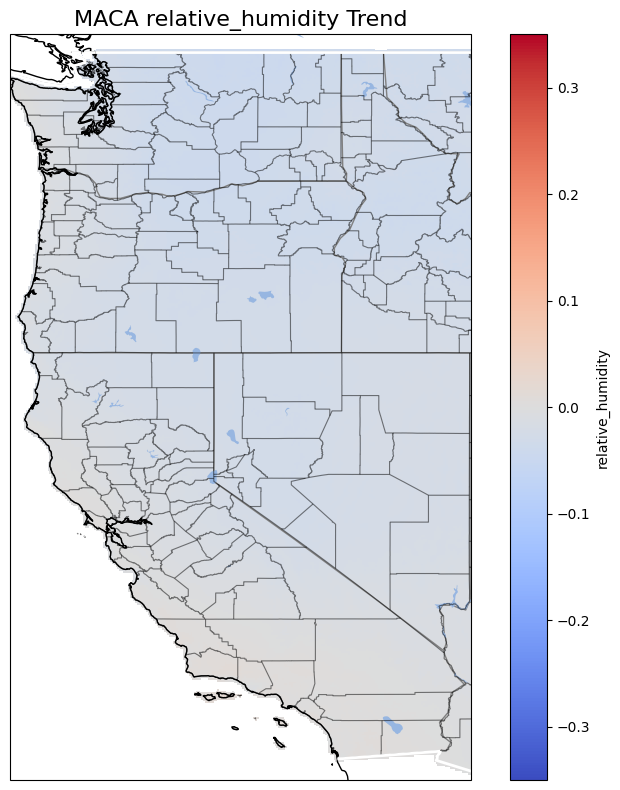

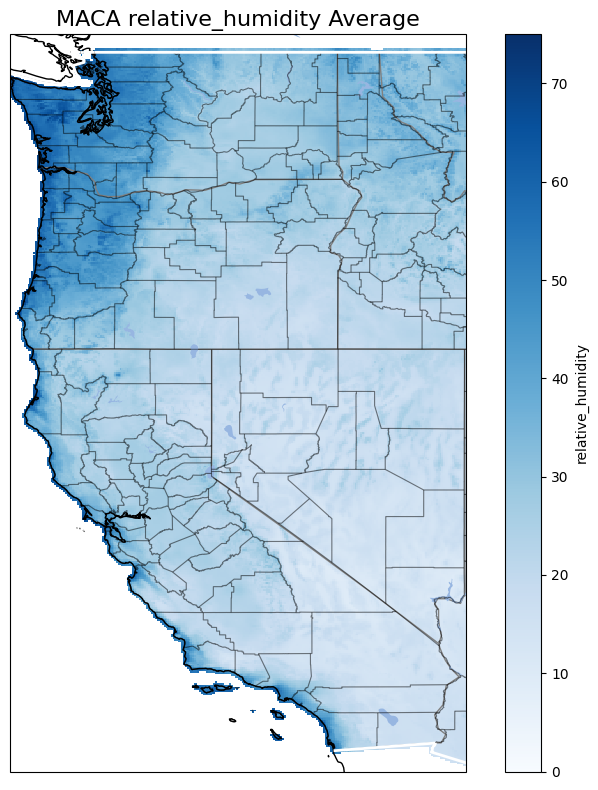

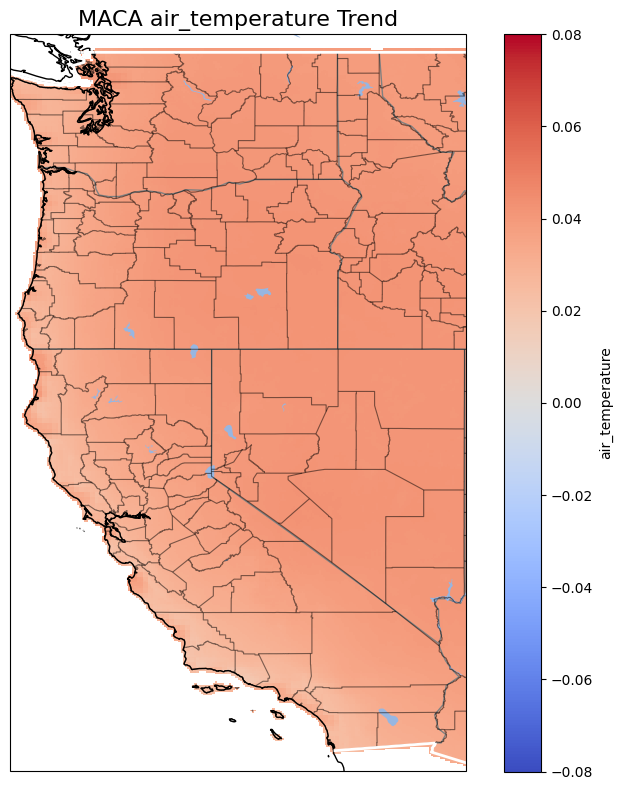

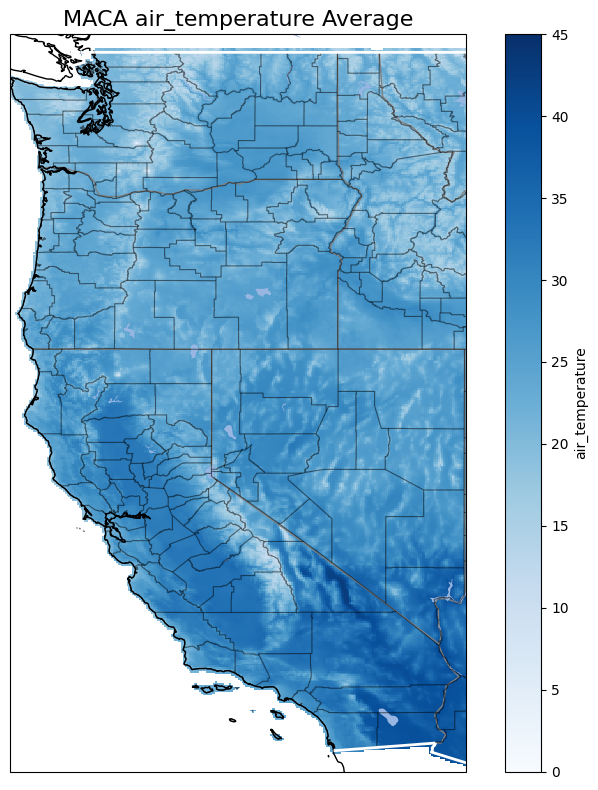

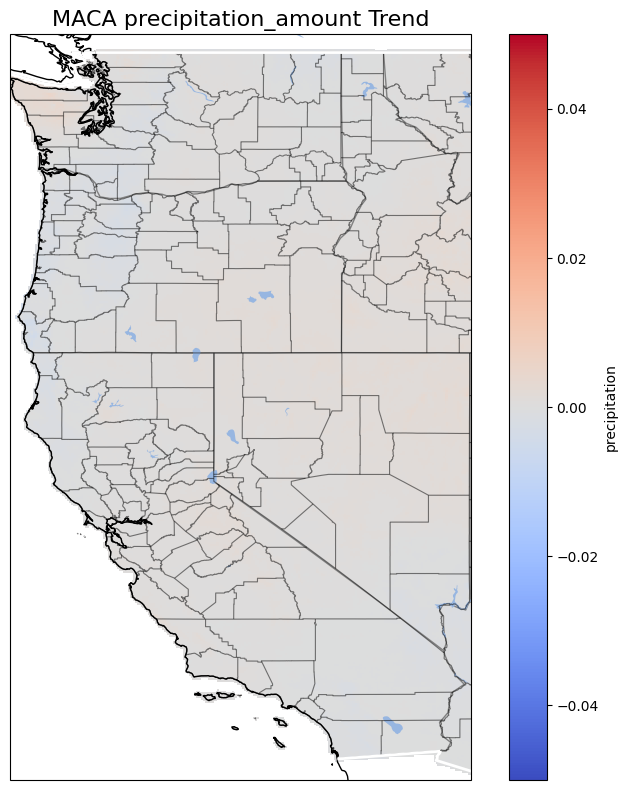

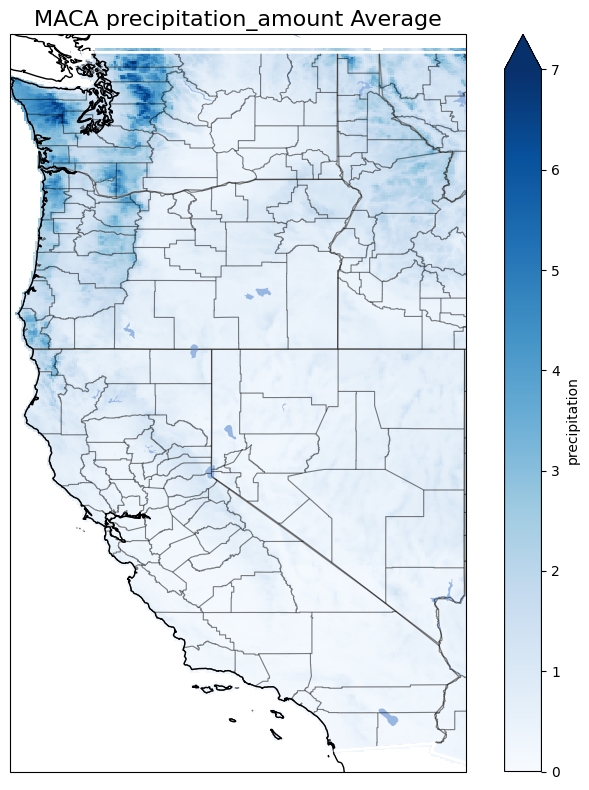

In [7]:
for i, input_field in enumerate(fwi_input_fields):
    results = []
    for model_i in models:
        out = dask.delayed(model_trend)(model_i)
        results.append(out)
    compute_tuple = dask.compute(*results)
    trend_list, historical_summer_avg_list = zip(*compute_tuple)
    combined = xr.concat(trend_list, dim="ensemble")
    ensemble_mean = combined.mean(dim="ensemble")
    ensemble_mean.load()

    # now plotting trends ###################################################################################
    if input_field_long[i] == 'air_temperature':
        vmin = -0.08
        vmax = 0.08

    if input_field_long[i] == 'relative_humidity':
        vmin = -0.35
        vmax = 0.35

    if input_field_long[i] == 'precipitation_amount':
        vmin = -0.05
        vmax = 0.05
        
    reader = shpreader.Reader('/storage/work/cta5244/2024_FWI_CMIP5_Ensemble_Avila/county_shapefile/countyl010g.shp')
    counties = list(reader.geometries())
    
    COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())
    
    scale = '110m'
    states110 = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_1_states_provinces_lines',
                scale=scale,
                facecolor='none',
                edgecolor='r')
    
    
    cmap='coolwarm'
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ensemble_mean.plot(ax=ax,cmap=cmap, vmin=vmin, vmax=vmax)
    
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
    ax.coastlines()
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')
    
    
    plt.title(f'MACA {input_field_long[i]} Trend', fontsize=16)
    fig.tight_layout()
    plt.savefig(f'/storage/work/cta5244/2024_FWI_CMIP5_Ensemble_Avila/revision_notebooks/revision_figures/1a_MACA_FWI_Inputs_{input_field_long[i]}_1979_2022_Trend')

    # now the historical avg for summer months #########################################################
    combined = xr.concat(historical_summer_avg_list, dim="ensemble")
    ensemble_mean = combined.mean(dim="ensemble")
    ensemble_mean.load()

    if input_field_long[i] == 'air_temperature':
        ensemble_mean = ensemble_mean - 273.15
        vmin = 0.0
        vmax = 45.0

    if input_field_long[i] == 'relative_humidity':
        vmin = 0.0
        vmax = 75.0

    if input_field_long[i] == 'precipitation_amount':
        vmin = 0.0
        vmax = 7.0
        
    reader = shpreader.Reader('/storage/work/cta5244/2024_FWI_CMIP5_Ensemble_Avila/county_shapefile/countyl010g.shp')
    counties = list(reader.geometries())
    
    COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())
    
    scale = '110m'
    states110 = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_1_states_provinces_lines',
                scale=scale,
                facecolor='none',
                edgecolor='r')
    
    
    cmap='Blues'
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ensemble_mean[list(ensemble_mean.keys())[0]].plot(ax=ax,cmap=cmap, vmin=vmin, vmax=vmax)
    
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
    ax.coastlines()
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')
    
    
    plt.title(f'MACA {input_field_long[i]} Average', fontsize=16)
    fig.tight_layout()
    plt.savefig(f'/storage/work/cta5244/2024_FWI_CMIP5_Ensemble_Avila/revision_notebooks/revision_figures/1a_MACA_FWI_Inputs_{input_field_long[i]}_1979_2022_Average')

## Wind Speed

In [8]:
file_in_hist_MACA = "/storage/group/pches/default/public/MACA-CMIP5/windspeed_files/historical/macav2metdata_ws_"
file_in_rcp45_MACA = "/storage/group/pches/default/public/MACA-CMIP5/windspeed_files/rcp45/macav2metdata_ws_"
maca_v2_paths = sorted(glob.glob(f'{file_in_hist_MACA}*'))
start_year, end_year = 1979, 2025
start_year, end_year = 1979, 2025
lon_max = -114.016667
lon_min = -124.766667
lat_min = 32.025
lat_max = 50
start_day = 152
end_day = 304

In [13]:
def model_vs(model_i):
    '''
    given some model name, the avg & slope map for vs 
    inputs
    - model_i
    outputs
    - single model trend & average for vs 
    '''
    mavav2_hist_paths = f'{file_in_hist_MACA}{model_i}*'
    mavav2_rcp45_paths = f'{file_in_rcp45_MACA}{model_i}*'
    sorted_hist_paths = sorted(glob.glob(mavav2_hist_paths))
    sorted_rcp45_paths = sorted(glob.glob(mavav2_rcp45_paths))
    all_paths = sorted_hist_paths + (sorted_rcp45_paths)
    correct_paths = []
    for path_i in all_paths:
        start_year_i = int(path_i.split("_")[-4])
        end_year_i = int(path_i.split("_")[-3])
        if ((start_year_i >= start_year) and (end_year_i <= end_year)) or (end_year_i == start_year) or (start_year_i == end_year):
            correct_paths.append(path_i)
    ds_model_i_ws = xr.open_mfdataset(correct_paths)
    ds_model_i_ws["lon"] = np.where(ds_model_i_ws["lon"] > 180, ds_model_i_ws["lon"] - 360, ds_model_i_ws["lon"])
    ds_model_i_ws = ds_model_i_ws.where((ds_model_i_ws.lon >= lon_min) & (ds_model_i_ws.lon <= lon_max) & 
                                    (ds_model_i_ws.lat >= lat_min) & (ds_model_i_ws.lat <= lat_max), drop=True)
    ds_model_i_ws = ds_model_i_ws.sel(time=~((ds_model_i_ws.time.dt.month == 2) & (ds_model_i_ws.time.dt.day == 29)))
    ds_model_i_ws = ds_model_i_ws.sel(time=slice('1979-01-01', '2022-12-31')).compute()
    
    mask = (ds_model_i_ws["time"].dt.dayofyear >= start_day) & (ds_model_i_ws["time"].dt.dayofyear <= end_day)
    ds_model_i_ws = ds_model_i_ws.where(mask, drop=True)
    ds_annual = ds_model_i_ws.groupby("time.year").mean(dim="time")
    key = list(ds_annual.keys())[0]
    yearly_mean = ds_annual.mean(dim='year')
    poly_coeffs = ds_annual[key].polyfit(dim="year", deg=1)
    poly_coeffs_key = list(poly_coeffs.keys())[0]
    poly_coeffs = poly_coeffs.rename({poly_coeffs_key:key})
    poly_fits = xr.polyval(coord=ds_annual["year"], coeffs=poly_coeffs)
    trendline =  poly_coeffs.sel(degree=1)[key]
    return trendline, yearly_mean

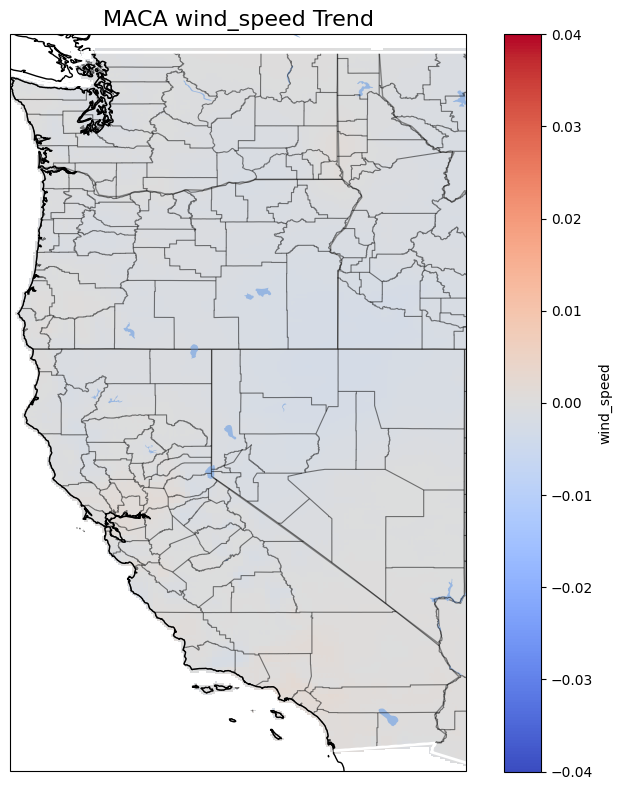

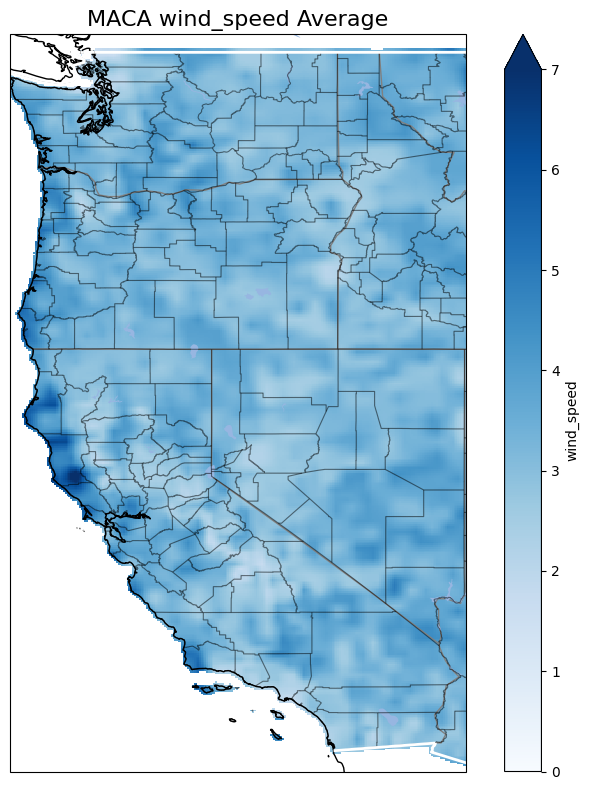

In [14]:
results = []
for model_i in models:
    out = dask.delayed(model_vs)(model_i)
    results.append(out)
compute_tuple = dask.compute(*results)
trend_list, historical_summer_avg_list = zip(*compute_tuple)
combined = xr.concat(trend_list, dim="ensemble")
ensemble_mean = combined.mean(dim="ensemble")
ensemble_mean.load()
reader = shpreader.Reader('/storage/work/cta5244/2024_FWI_CMIP5_Ensemble_Avila/county_shapefile/countyl010g.shp')
counties = list(reader.geometries())

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

scale = '110m'
states110 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale=scale,
            facecolor='none',
            edgecolor='r')


cmap='coolwarm'
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ensemble_mean.plot(ax=ax,cmap=cmap, vmin=-.04, vmax=.04)

ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
ax.coastlines()
ax.add_feature(cfeature.LAKES)
ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')

plt.title(f'MACA wind_speed Trend', fontsize=16)
fig.tight_layout()
plt.savefig(f'/storage/work/cta5244/2024_FWI_CMIP5_Ensemble_Avila/revision_notebooks/revision_figures/1a_MACA_FWI_Inputs_wind_speed_1979_2022_Trend')

# now the historical avg for summer months #########################################################
combined = xr.concat(historical_summer_avg_list, dim="ensemble")
ensemble_mean = combined.mean(dim="ensemble")
ensemble_mean.load()
    
reader = shpreader.Reader('/storage/work/cta5244/2024_FWI_CMIP5_Ensemble_Avila/county_shapefile/countyl010g.shp')
counties = list(reader.geometries())

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

scale = '110m'
states110 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale=scale,
            facecolor='none',
            edgecolor='r')


cmap='Blues'
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ensemble_mean['wind_speed'].plot(ax=ax,cmap=cmap, vmin=0.0, vmax=7.0)

ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
ax.coastlines()
ax.add_feature(cfeature.LAKES)
ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')

plt.title(f'MACA wind_speed Average', fontsize=16)
fig.tight_layout()
plt.savefig(f'/storage/work/cta5244/2024_FWI_CMIP5_Ensemble_Avila/revision_notebooks/revision_figures/1a_MACA_FWI_Inputs_wind_speed_1979_2022_Average')